# **Import librares**

In [ ]:
! pip install Keras-Preprocessing
! pip install textblob
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import joblib
from collections import Counter
from textblob import Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.sequence import pad_sequences
# from keras.utils.np_utils import to_categorical
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
import re
! pip install ktrain
import ktrain
from ktrain import text
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from textblob import Word
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('gutenberg')
nltk.download('brown')
nltk.download("reuters")
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### **Load Dataset**

In [ ]:
df_tweet_multi=pd.read_json('/content/CETM47-23_24-AS2-Data.json', encoding='latin-1')
df_tweet_multi['label_name'].value_counts()

label_name
pop_culture                 2512
sports_&_gaming             2291
daily_life                   883
science_&_technology         326
business_&_entrepreneurs     287
arts_&_culture               144
Name: count, dtype: int64

In [ ]:
df_tweet_multi

text       date  label  \
0     The {@Clinton LumberKings@} beat the {@Cedar R... 2019-09-08      4   
1     I would rather hear Eli Gold announce this Aub... 2019-09-08      4   
2     Someone take my phone away, I’m trying to not ... 2019-09-08      4   
3     A year ago, Louisville struggled to beat an FC... 2019-09-08      4   
4     Anyone know why the #Dodgers #Orioles game nex... 2019-09-08      4   
...                                                 ...        ...    ...   
6438  Praying for {{USERNAME}} family friends riding... 2021-08-29      3   
6439  Etsy: {{USERNAME}} Hi there, I m sorry to hear... 2021-08-29      1   
6440  Imagine how hard it is to be a Teume. Everyone... 2021-08-29      2   
6441  Ride With Me - Mental Health Awareness Charity... 2021-08-29      2   
6442  Prediction: The future of CX in {@McKinsey Com... 2021-08-29      1   

                       id                label_name  
0     1170516324419866624           sports_&_gaming  
1     1170516440690176006           sports_&_gaming  
2     1170516543387709440           sports_&_gaming  
3     1170516620466429953           sports_&_gaming  
4     1170516711411310592           sports_&_gaming  
...                   ...                       ...  
6438  1431979856120762370                daily_life  
6439  1432008666018942977  business_&_entrepreneurs  
6440  1432008666803097606               pop_culture  
6441  1432069101753491456               pop_culture  
6442  1432099700614774784  business_&_entrepreneurs  

[6443 rows x 5 columns]

# **Data Cleaning**

In [ ]:
df_tweet_multi['text']=df_tweet_multi['text'].fillna("")
df_tweet_multi.isna().sum()

text          0
date          0
label         0
id            0
label_name    0
dtype: int64

# **Preprocessing**

In [ ]:
def preprocess_text(df_tweet_multi, text_column):
    """
    Preprocesses the text data in the specified column of the DataFrame.

    This function performs several preprocessing steps:
    1. Converts text to lowercase, strips leading/trailing spaces, and replaces newlines with spaces.
    2. Removes non-alphabetic characters and non-ASCII characters.
    3. Removes links from the text.
    4. Tokenizes the text into words.
    5. Removes stopwords, with some exceptions.
    6. Filters out words that are shorter than 2 characters.
    7. Lemmatizes the words.

    Parameters:
    df_tweet_multi (pd.DataFrame): The DataFrame containing the text data.
    text_column (str): The name of the column containing the text to preprocess.

    Returns:
    pd.DataFrame: A DataFrame with a new column 'processed_text' containing the preprocessed text.
    """

    # Convert text to lowercase and clean spaces and newlines
    df_tweet_multi['lower_case'] = df_tweet_multi[text_column].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))

    # Remove non-alphabetic characters and non-ASCII characters
    df_tweet_multi['alphabatic'] = df_tweet_multi['lower_case'].apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ', x))
    df_tweet_multi['alphabatic'] = df_tweet_multi['alphabatic'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    # Remove links from the text
    df_tweet_multi['without_link'] = df_tweet_multi['alphabatic'].apply(lambda x: re.sub(r'http\S+', '', x))

    # Tokenize the text into words
    tokenizer = RegexpTokenizer(r'\w+')
    df_tweet_multi['Special_word'] = df_tweet_multi['without_link'].apply(lambda x: tokenizer.tokenize(x))

    # Remove stopwords, with some exceptions
    stop = [word for word in stopwords.words('english') if word not in [
        "my", "haven't", "aren't", "can", "no", "why", "through", "herself",
        "she", "he", "himself", "you", "you're", "myself", "not", "here",
        "some", "do", "does", "did", "will", "don't", "doesn't", "didn't",
        "won't", "should", "should've", "couldn't", "mightn't", "mustn't",
        "shouldn't", "hadn't", "wasn't", "wouldn't", 'url', 'username',
    ]]

    df_tweet_multi['stop_words'] = df_tweet_multi['Special_word'].apply(lambda x: [item for item in x if item not in stop])

    # Filter out words that are shorter than 2 characters
    df_tweet_multi['short_word'] = df_tweet_multi['stop_words'].apply(lambda x: [word for word in x if len(word) >= 2])

    # Join the words back into a single string
    df_tweet_multi['string'] = df_tweet_multi['short_word'].apply(lambda x: ' '.join(x))

    # Lemmatize the words
    df_tweet_multi['processed_text'] = df_tweet_multi['string'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    # Drop the intermediate columns
    df_tweet_multi.drop(columns=['lower_case', 'alphabatic', 'without_link', 'Special_word', 'stop_words', 'short_word', 'string'], inplace=True)

    return df_tweet_multi


In [ ]:
df_tweet_multi = preprocess_text(df_tweet_multi, 'text')


In [ ]:
df_tweet_multi

text       date  label  \
0     The {@Clinton LumberKings@} beat the {@Cedar R... 2019-09-08      4   
1     I would rather hear Eli Gold announce this Aub... 2019-09-08      4   
2     Someone take my phone away, I’m trying to not ... 2019-09-08      4   
3     A year ago, Louisville struggled to beat an FC... 2019-09-08      4   
4     Anyone know why the #Dodgers #Orioles game nex... 2019-09-08      4   
...                                                 ...        ...    ...   
6438  Praying for {{USERNAME}} family friends riding... 2021-08-29      3   
6439  Etsy: {{USERNAME}} Hi there, I m sorry to hear... 2021-08-29      1   
6440  Imagine how hard it is to be a Teume. Everyone... 2021-08-29      2   
6441  Ride With Me - Mental Health Awareness Charity... 2021-08-29      2   
6442  Prediction: The future of CX in {@McKinsey Com... 2021-08-29      1   

                       id                label_name  \
0     1170516324419866624           sports_&_gaming   
1     1170516440690176006           sports_&_gaming   
2     1170516543387709440           sports_&_gaming   
3     1170516620466429953           sports_&_gaming   
4     1170516711411310592           sports_&_gaming   
...                   ...                       ...   
6438  1431979856120762370                daily_life   
6439  1432008666018942977  business_&_entrepreneurs   
6440  1432008666803097606               pop_culture   
6441  1432069101753491456               pop_culture   
6442  1432099700614774784  business_&_entrepreneurs   

                                         processed_text  
0     clinton lumberkings beat cedar rapid kernel ga...  
1     would rather hear eli gold announce auburn gam...  
2     someone take my phone away trying not look chi...  
3     year ago louisville struggled beat fcs opponen...  
4     anyone know why dodger oriole game next thursd...  
...                                                 ...  
6438  praying username family friend riding ida safe...  
6439  etsy username hi sorry hear account closed do ...  
6440  imagine hard teume everyone u look u fighting ...  
6441  ride mental health awareness charity cycle rid...  
6442  prediction future cx mckinsey company quarterl...  

[6443 rows x 6 columns]

## Visualization

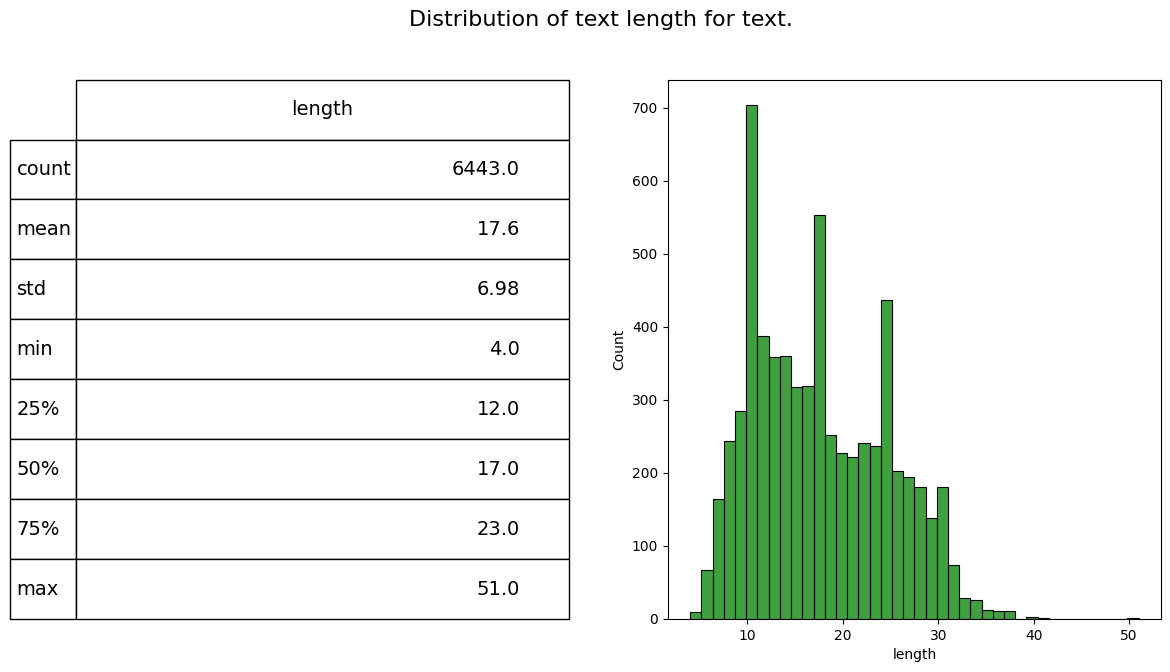

In [ ]:
fig = plt.figure(figsize=(14,7))
df_tweet_multi['length'] = df_tweet_multi.processed_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df_tweet_multi['length'], ax=ax1,color='green')
describe = df_tweet_multi.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for text.', fontsize=16)

plt.show()

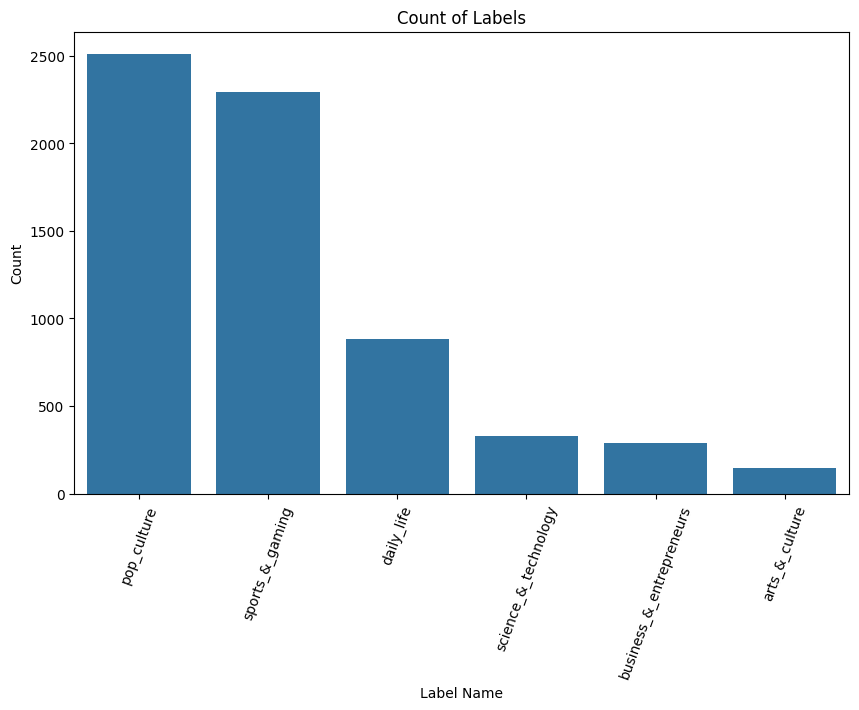

In [ ]:

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create the bar plot using value counts
label_counts = df_tweet_multi['label_name'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)

# Rotate the x-axis labels to be vertical
plt.xticks(rotation=70)

# Optionally, add a title and labels
plt.title('Count of Labels')
plt.xlabel('Label Name')
plt.ylabel('Count')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(df_tweet_multi, label_column, text_column, label_value):
    """
    Generates and displays a word cloud for a specific label value.

    Parameters:
    df_tweet_multi (pd.DataFrame): The DataFrame containing the data.
    label_column (str): The name of the column containing the labels.
    text_column (str): The name of the column containing the text data.
    label_value (str): The specific label value to filter the text data.

    Returns:
    None
    """

    # Join all the text entries for the specified label
    normal_words = ' '.join(df_tweet_multi[text_column][df_tweet_multi[label_column] == label_value])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

    # Plot the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Word Cloud for {label_value}')
    plt.show()

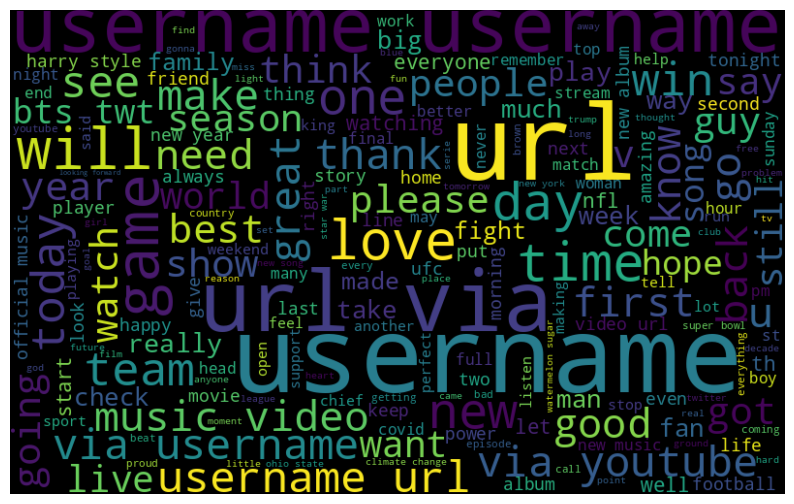

In [ ]:
normal_words =' '.join([text for text in df_tweet_multi['processed_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

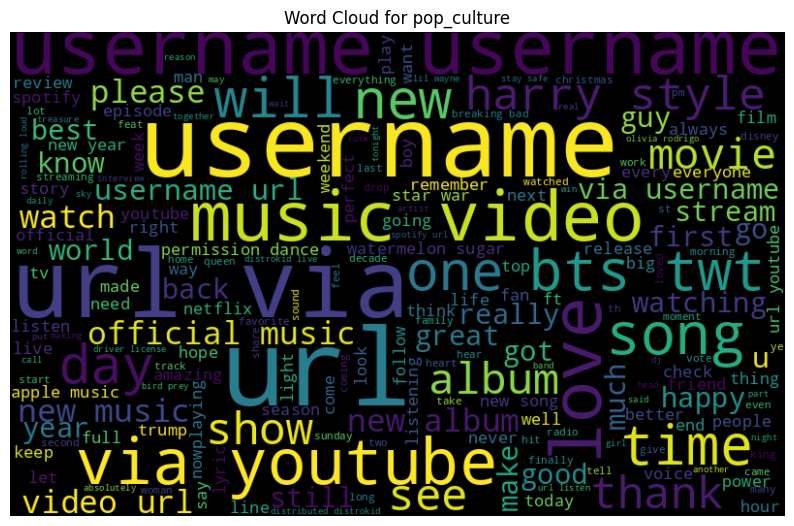

In [ ]:
generate_wordcloud(df_tweet_multi, 'label_name', 'processed_text', 'pop_culture')

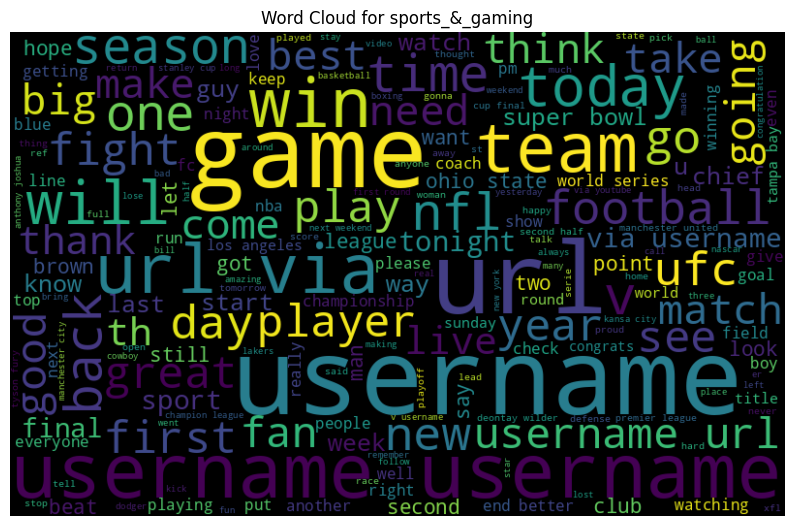

In [ ]:
generate_wordcloud(df_tweet_multi, 'label_name', 'processed_text', 'sports_&_gaming')

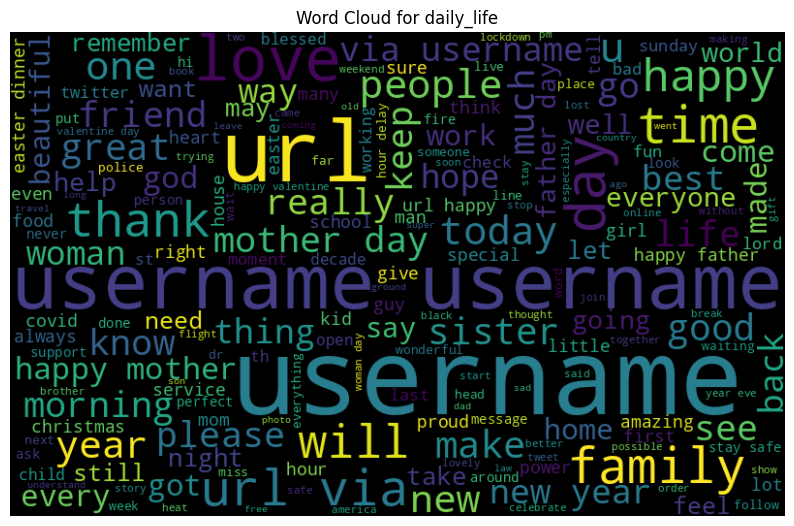

In [ ]:
generate_wordcloud(df_tweet_multi, 'label_name', 'processed_text', 'daily_life')

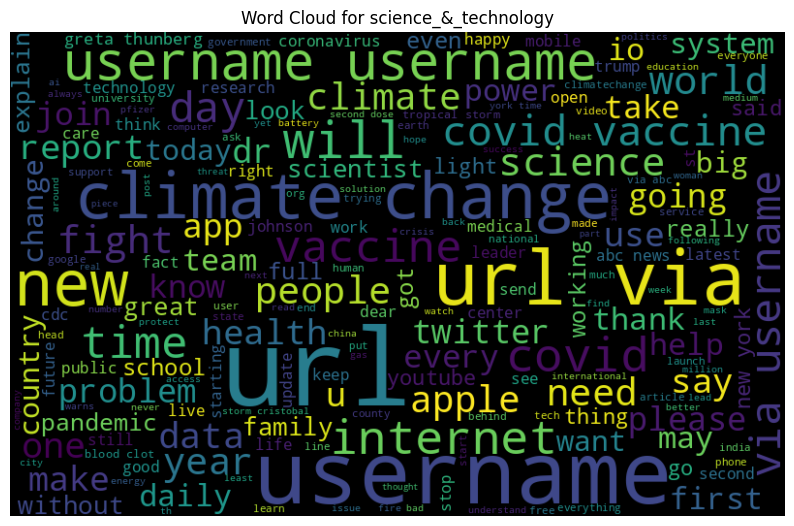

In [ ]:
generate_wordcloud(df_tweet_multi, 'label_name', 'processed_text', 'science_&_technology')

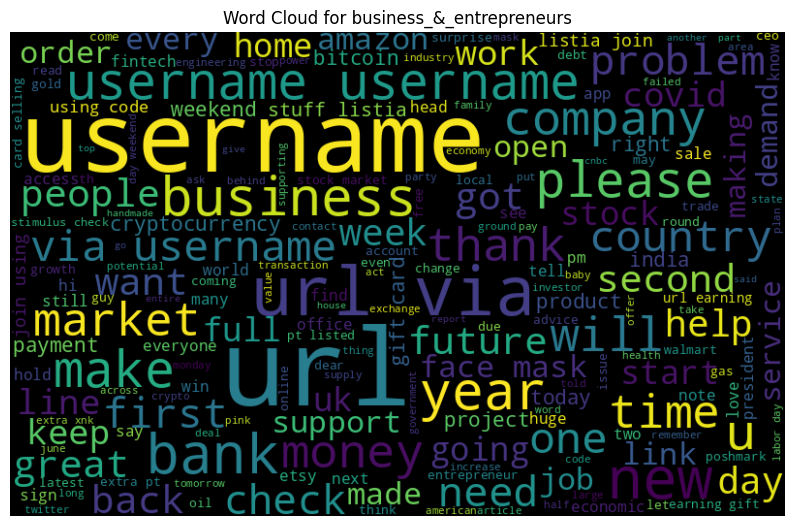

In [ ]:
generate_wordcloud(df_tweet_multi, 'label_name', 'processed_text', 'business_&_entrepreneurs')

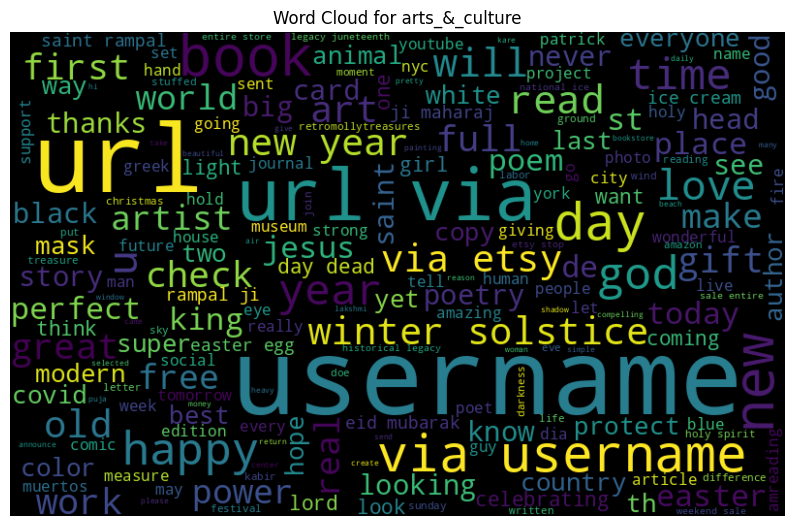

In [ ]:
generate_wordcloud(df_tweet_multi, 'label_name', 'processed_text', 'arts_&_culture')

## Data Splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_tweet_multi["processed_text"],df_tweet_multi["label"], test_size = 0.25, random_state = 42)

In [ ]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')


x_train shape: (4832,)
y_train shape: (4832,)
x_test shape: (1611,)
y_test shape: (1611,)


# Modelling

### Helper functions for plots

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Your model evaluation code here


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_multiclass_roc_curve(y_true, y_scores, model_name, n_classes):
    """
    Plots the ROC curve for a multiclass problem.

    Parameters:
    y_true: array-like of shape (n_samples,)
        True labels.
    y_scores: array-like of shape (n_samples, n_classes)
        Predicted scores/probabilities for each class.
    model_name: str
        Name of the model (for the plot title).
    n_classes: int
        Number of classes.
    """
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[i for i in range(n_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

def plot_multiclass_precision_recall_curve(y_true, y_scores, model_name, n_classes):
    """
    Plots the Precision-Recall curve for a multiclass problem.

    Parameters:
    y_true: array-like of shape (n_samples,)
        True labels.
    y_scores: array-like of shape (n_samples, n_classes)
        Predicted scores/probabilities for each class.
    model_name: str
        Name of the model (for the plot title).
    n_classes: int
        Number of classes.
    """
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[i for i in range(n_classes)])

    # Compute Precision-Recall and plot curve for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_scores[:, i])

    # Compute micro-average Precision-Recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_scores.ravel())
    average_precision["micro"] = average_precision_score(y_true_bin, y_scores, average="micro")

    plt.figure()
    plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4, label=f'micro-average Precision-Recall curve (AP = {average_precision["micro"]:.2f})')

    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Precision-Recall curve of class {i} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots the confusion matrix for the given true and predicted labels.

    Parameters:
    y_true: array-like of shape (n_samples,)
        True labels.
    y_pred: array-like of shape (n_samples,)
        Predicted labels.
    model_name: str
        Name of the model (for the plot title).
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## **Training Base model**

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
def train_and_evaluate_models(x_train, y_train, x_test, y_test):
    """
    Train and evaluate multiple classifiers without hyperparameters.

    Parameters:
    x_train: Training feature set
    y_train: Training labels
    x_test: Testing feature set
    y_test: Testing labels

    Returns:
    dict: A dictionary containing evaluation metrics for each model.
    """
    # Print shapes to debug the issue
    print(f'x_train shape: {x_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'x_test shape: {x_test.shape}')
    print(f'y_test shape: {y_test.shape}')

    models = {
        'Logistic Regression': LogisticRegression(),
        'Linear SVC': LinearSVC(),
        'Multinomial NB': MultinomialNB(),
        'Random Forest': RandomForestClassifier()
    }

    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1 Score (Macro)': [],
        'Recall (Micro)': [],
        'Precision (Micro)': [],
        'ROC AUC': [],
        'PR AUC': []
    }

    for name, model in models.items():
        print(f'Starting Training for {name} classifier')
        m = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf_tweet_multi', TfidfTransformer(norm='l2', sublinear_tf=True)),
                      ('model', model),
                     ])

        m.fit(x_train, y_train)
        y_pred = m.predict(x_test)

        if hasattr(m, "predict_proba"):
            y_scores = m.predict_proba(x_test)
        else:  # use decision function for estimators that do not have predict_proba
            y_scores = m.decision_function(x_test)

        print(f"Model: {name}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print(classification_report(y_test, y_pred))
        print("\n")

        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, name)

        # Plot ROC curve and compute AUC
        n_classes = len(set(y_train))
        plot_multiclass_roc_curve(y_test, y_scores, name, n_classes)
        roc_auc = auc(*roc_curve(label_binarize(y_test, classes=[i for i in range(n_classes)]).ravel(), y_scores.ravel())[:2])

        # Plot Precision-Recall curve and compute AUC
        plot_multiclass_precision_recall_curve(y_test, y_scores, name, n_classes)
        pr_auc = average_precision_score(label_binarize(y_test, classes=[i for i in range(n_classes)]), y_scores, average="micro")

        metrics['Model'].append(name)
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred) * 100)
        metrics['F1 Score (Macro)'].append(f1_score(y_test, y_pred, average='macro') * 100)
        metrics['Recall (Micro)'].append(recall_score(y_test, y_pred, average='micro') * 100)
        metrics['Precision (Micro)'].append(precision_score(y_test, y_pred, average='micro') * 100)
        metrics['ROC AUC'].append(roc_auc)
        metrics['PR AUC'].append(pr_auc)

    return metrics


x_train shape: (4832,)
y_train shape: (4832,)
x_test shape: (1611,)
y_test shape: (1611,)
Starting Training for Logistic Regression classifier
Model: Logistic Regression
Accuracy: 0.798261949099938
              precision    recall  f1-score   support

           0       0.50      0.07      0.12        30
           1       1.00      0.19      0.32        74
           2       0.80      0.90      0.85       621
           3       0.71      0.58      0.64       230
           4       0.82      0.94      0.88       588
           5       0.75      0.35      0.48        68

    accuracy                           0.80      1611
   macro avg       0.76      0.50      0.55      1611
weighted avg       0.80      0.80      0.77      1611





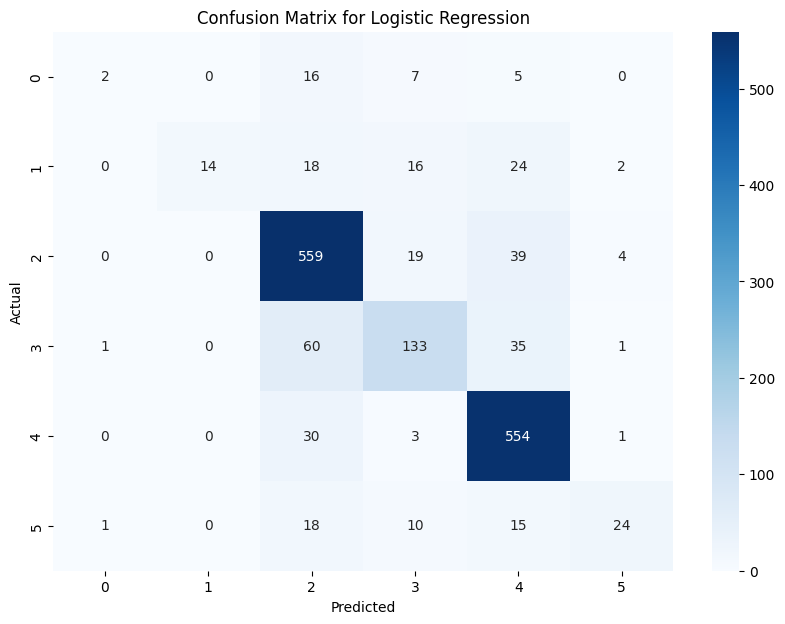

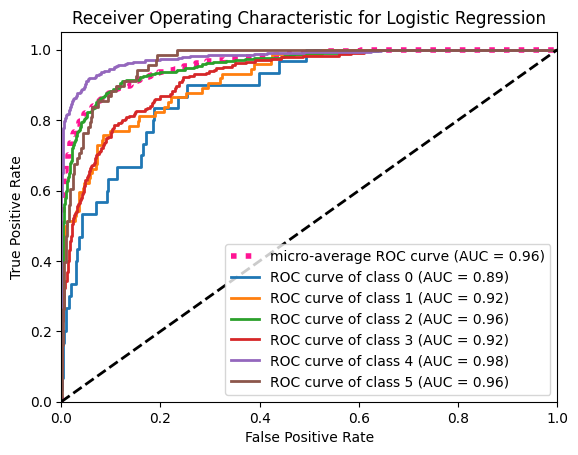

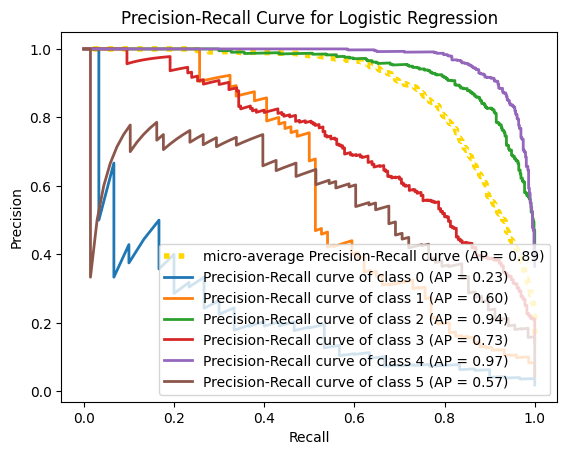

Starting Training for Linear SVC classifier
Model: Linear SVC
Accuracy: 0.8063314711359404
              precision    recall  f1-score   support

           0       0.42      0.17      0.24        30
           1       0.77      0.45      0.56        74
           2       0.84      0.85      0.85       621
           3       0.63      0.66      0.64       230
           4       0.87      0.92      0.89       588
           5       0.64      0.60      0.62        68

    accuracy                           0.81      1611
   macro avg       0.69      0.61      0.63      1611
weighted avg       0.80      0.81      0.80      1611





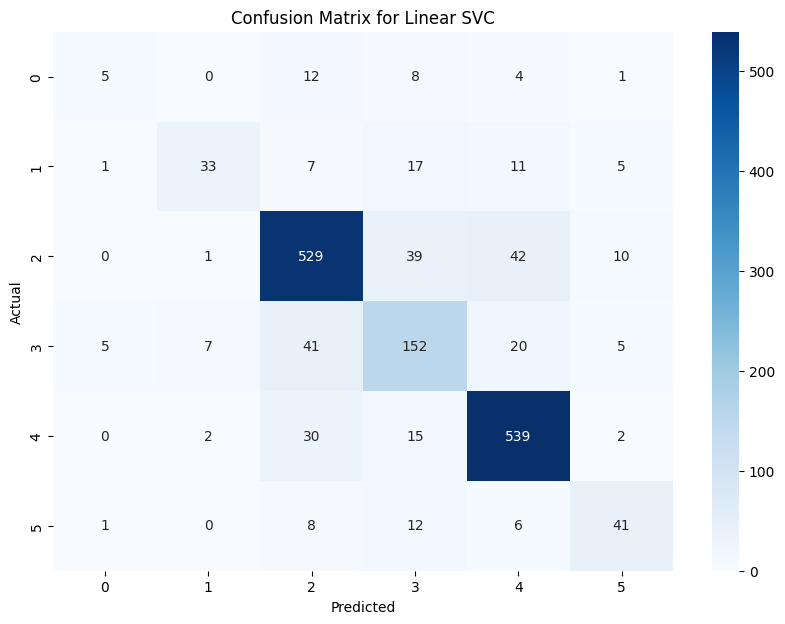

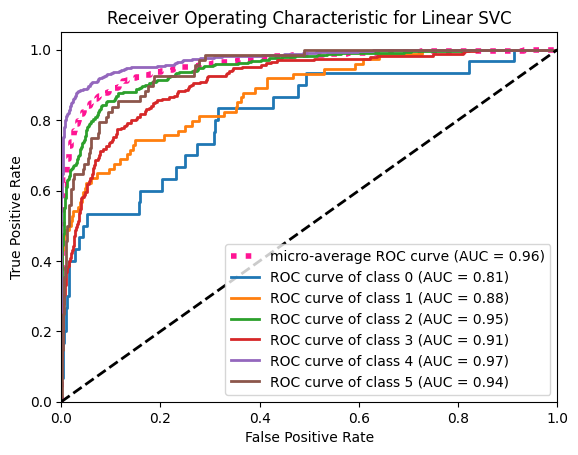

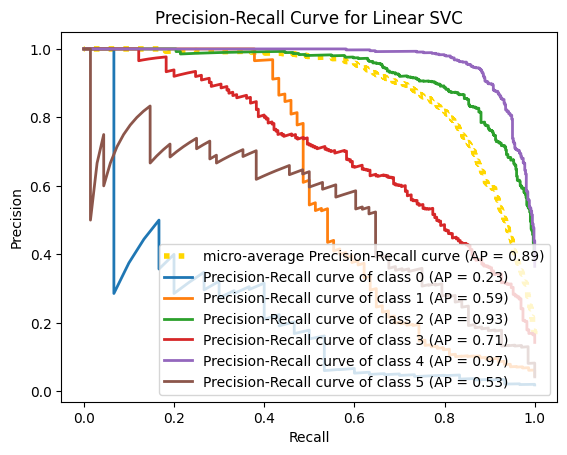

Starting Training for Multinomial NB classifier
Model: Multinomial NB
Accuracy: 0.7566728739913098
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.80      0.05      0.10        74
           2       0.72      0.91      0.81       621
           3       0.77      0.37      0.50       230
           4       0.79      0.95      0.86       588
           5       0.75      0.13      0.23        68

    accuracy                           0.76      1611
   macro avg       0.64      0.40      0.42      1611
weighted avg       0.75      0.76      0.71      1611





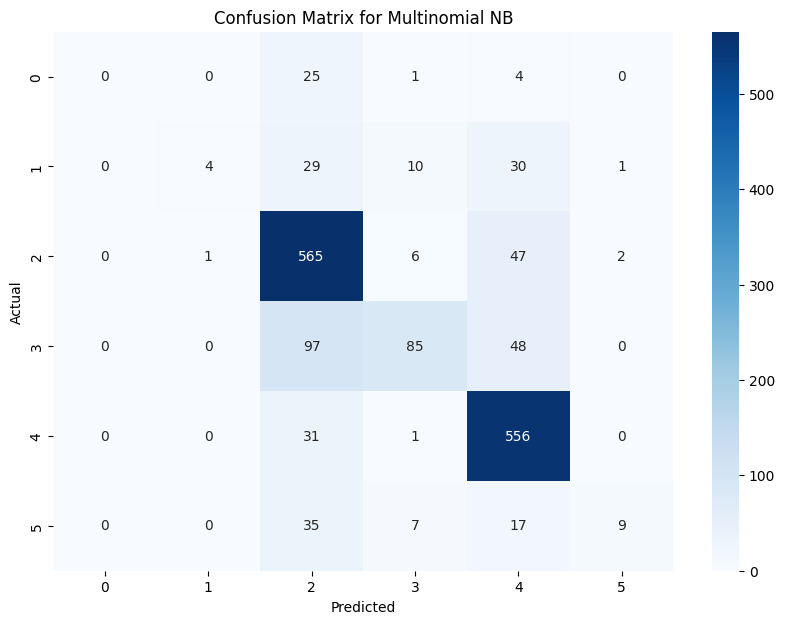

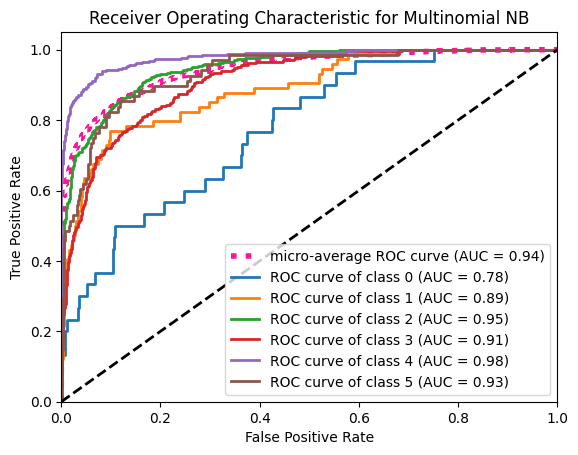

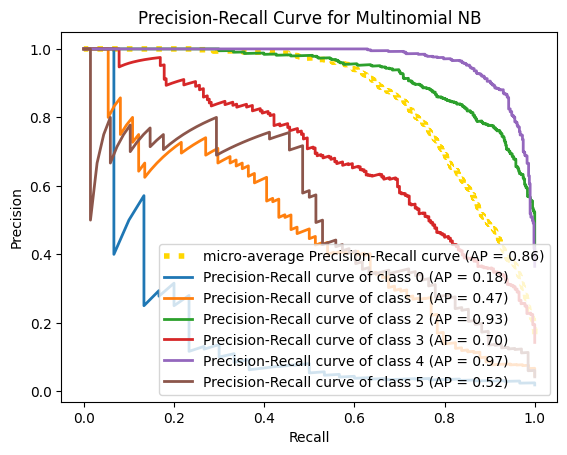

Starting Training for Random Forest classifier
Model: Random Forest
Accuracy: 0.749844816883923
              precision    recall  f1-score   support

           0       1.00      0.07      0.12        30
           1       0.95      0.24      0.39        74
           2       0.70      0.89      0.78       621
           3       0.69      0.47      0.55       230
           4       0.83      0.86      0.84       588
           5       0.67      0.35      0.46        68

    accuracy                           0.75      1611
   macro avg       0.80      0.48      0.53      1611
weighted avg       0.76      0.75      0.73      1611





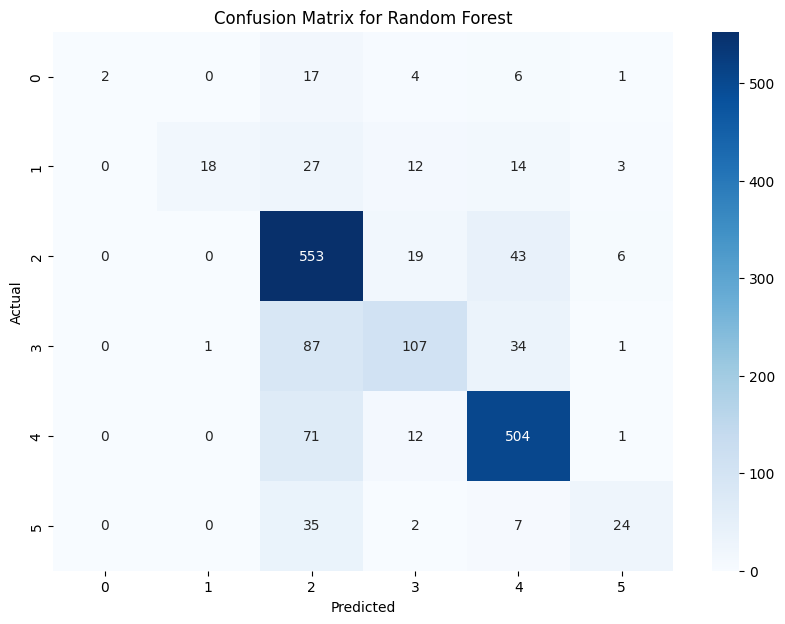

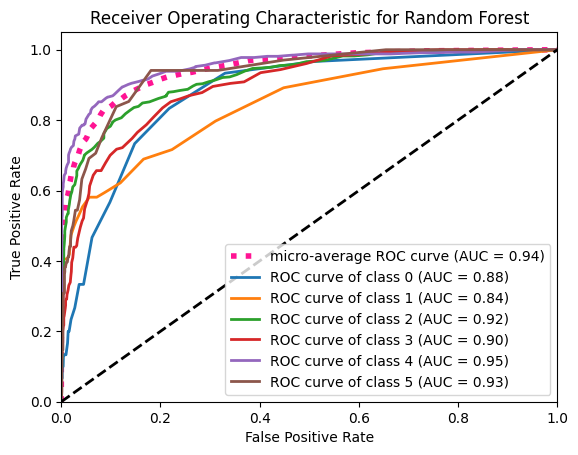

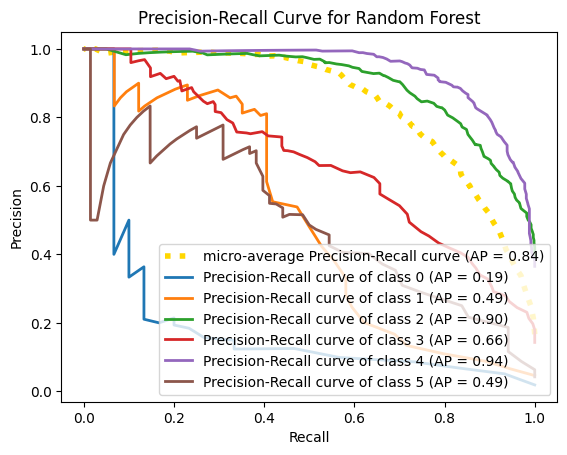

In [ ]:
metric_df_tweet_multi = train_and_evaluate_models(x_train, y_train, x_test, y_test)

In [ ]:
metric_df_tweet_multi = pd.DataFrame(metric_df_tweet_multi)
metric_df_tweet_multi

Model   Accuracy  F1 Score (Macro)  Recall (Micro)  \
0  Logistic Regression  79.826195         54.620766       79.826195   
1           Linear SVC  80.633147         63.413026       80.633147   
2       Multinomial NB  75.667287         41.561638       75.667287   
3        Random Forest  74.984482         52.578167       74.984482   

   Precision (Micro)   ROC AUC    PR AUC  
0          79.826195  0.960684  0.888374  
1          80.633147  0.957916  0.887844  
2          75.667287  0.944175  0.857478  
3          74.984482  0.944983  0.842911

# Pipeline and GridSearchCV with Hyperparameter

Starting Training for Logistic Regression classifier


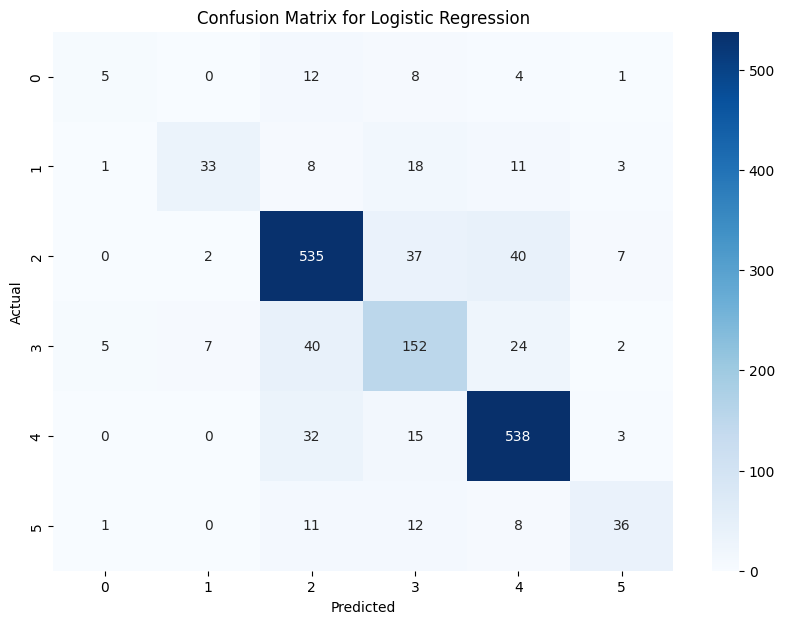

KeyError: 'ROC AUC'

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

def train_and_evaluate_models_with_pipeline_hyper(x_train, y_train, x_test, y_test):
    """
    Train and evaluate multiple classifiers using Pipeline and GridSearchCV to find the best hyperparameters.
    Collect performance metrics for comparison.

    Parameters:
    x_train: Training feature set
    y_train: Training labels
    x_test: Testing feature set
    y_test: Testing labels

    Returns:
    pd.DataFrame: DataFrame containing the performance metrics for each model.
    """

    # Define the models and their hyperparameter grids
    models = {
        'Logistic Regression': (LogisticRegression(), {'clf__C': [0.1, 1, 2, 10], 'clf__max_iter': [100, 500, 1000]}),
        'Linear SVC': (LinearSVC(), {'clf__C': [0.1, 1, 10]}),
        'Multinomial NB': (MultinomialNB(), {'clf__alpha': [0.1, 1, 10]}),
        'Random Forest': (RandomForestClassifier(), {'clf__n_estimators': [100, 200, 300], 'clf__max_depth': [10, 15, 20]})
    }

    # Dictionary to store the metrics
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1 Score (Macro)': [],
        'Recall (Micro)': [],
        'Precision (Micro)': []
    }

    for name, (model, params) in models.items():
        print(f'Starting Training for {name} classifier')
        # Create a pipeline with the TF-Idf_tweet_multi Vectorizer and the classifier
        pipeline = Pipeline([
            ('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
            ('tfidf_tweet_multi', TfidfTransformer(norm='l2',sublinear_tf=True)),
            ('clf', model)
        ])

        # Perform GridSearchCV with the pipeline
        grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(x_test)

        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, name)


        metrics['Model'].append(name)
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred) * 100)
        metrics['F1 Score (Macro)'].append(f1_score(y_test, y_pred, average='macro') * 100)
        metrics['Recall (Micro)'].append(recall_score(y_test, y_pred, average='micro') * 100)
        metrics['Precision (Micro)'].append(precision_score(y_test, y_pred, average='micro') * 100)

    # Convert the metrics dictionary to a DataFrame
    comparison_df_tweet_multi = pd.DataFrame(metrics)
    return comparison_df_tweet_multi

comparison_df_tweet_multi = train_and_evaluate_models_with_pipeline_hyper(x_train, y_train, x_test, y_test)


In [ ]:
metric_df_tweet_mult_hyper = pd.DataFrame(comparison_df_tweet_multi)
metric_df_tweet_mult_hyper

Model   Accuracy  F1 Score (Macro)  Recall (Micro)  \
0  Logistic Regression  80.633147         63.134438       80.633147   
1           Linear SVC  80.633147         63.413026       80.633147   
2       Multinomial NB  80.509001         59.935251       80.509001   
3        Random Forest  69.335816         33.946850       69.335816   

   Precision (Micro)  
0          80.633147  
1          80.633147  
2          80.509001  
3          69.335816

## *Using Best model for Ensemble classifier*

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

def create_and_evaluate_ensemble_pipeline(x_train, y_train, x_test, y_test):
    """
    This function creates a text processing and ensemble classification pipeline,
    fits it to the training data, and evaluates it on the test data.

    The pipeline performs the following steps:
    1. Vectorizes the text data using CountVectorizer with n-grams (1,2) and min_df_tweet_multi=5.
    2. Transforms the count matrix into a TF-Idf_tweet_multi representation.
    3. Applies an ensemble classifier consisting of:
       - Multinomial Naive Bayes
       - Random Forest Classifier
       - Logistic Regression
       - Support Vector Machine
    The ensemble classifier uses soft voting and weighted averaging with specified weights.

    Parameters:
    x_train (array-like or sparse matrix): Training data features (text).
    y_train (array-like): Training data labels.
    x_test (array-like or sparse matrix): Test data features (text).
    y_test (array-like): Test data labels.

    Returns:
    dict: Dictionary containing model performance metrics.
    """
    # Define individual components of the ensemble
    mnb = MultinomialNB()
    rfc = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42)
    lr = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
    svc = SVC(probability=True)

    # Create the VotingClassifier
    ec = VotingClassifier(
        estimators=[
            ('Multinomial NB', mnb),
            ('Random Forest', rfc),
            ('Logistic Regression', lr),
            ('Support Vector Machine', svc)
        ],
        voting='soft',
        weights=[1, 2, 3, 4]
    )

    # Create the pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
        ('tfidf_tweet_multi', TfidfTransformer()),
        ('model', ec)
    ])

    # Fit the pipeline to the training data
    pipeline.fit(x_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(x_test)

    # Calculate metrics
    metrics = {
        'Model': 'Ensemble Voting Classifier',
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score (Macro)': f1_score(y_test, y_pred, average='macro'),
        'Recall (Micro)': recall_score(y_test, y_pred, average='micro'),
        'Precision (Micro)': precision_score(y_test, y_pred, average='micro')
    }

    # Print accuracy and classification report
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"F1 Score (Macro): {metrics['F1 Score (Macro)']}")
    print(f"Recall (Micro): {metrics['Recall (Micro)']}")
    print(f"Precision (Micro): {metrics['Precision (Micro)']}")
    print(classification_report(y_test, y_pred))

    return metrics

# Example usage:
# Assuming x_train, x_test, y_train, and y_test are already defined
metrics_ese = create_and_evaluate_ensemble_pipeline(x_train, y_train, x_test, y_test)
# print(metrics)


Accuracy: 0.8150217256362507
F1 Score (Macro): 0.6318697323100632
Recall (Micro): 0.8150217256362507
Precision (Micro): 0.8150217256362507
              precision    recall  f1-score   support

           0       0.50      0.13      0.21        30
           1       0.86      0.43      0.58        74
           2       0.82      0.88      0.85       621
           3       0.67      0.65      0.66       230
           4       0.87      0.93      0.90       588
           5       0.71      0.51      0.60        68

    accuracy                           0.82      1611
   macro avg       0.74      0.59      0.63      1611
weighted avg       0.81      0.82      0.81      1611



In [ ]:
metric_df_tweet_mult_ensemble = pd.DataFrame([metrics_ese])
metric_df_tweet_mult_ensemble

Model  Accuracy  F1 Score (Macro)  Recall (Micro)  \
0  Ensemble Voting Classifier  0.815022           0.63187        0.815022   

   Precision (Micro)  
0           0.815022

# **Deep Learning Model**

In [ ]:
vocabulary_size = 15000
max_text_len = 768
stemmer = SnowballStemmer('english')
stop_words = [word for word in stopwords.words('english') if word not in ["my","haven't","aren't","can","no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"]]

In [ ]:
def preprocess_text(text):

    text = re.sub('[^a-zA-Z]', ' ', text)

    words = text.lower().split()

    words = [stemmer.stem(word) for word in words if not word in stop_words]

    cleaned_text = ' '.join(words)
    return cleaned_text

df_tweet_multi['cleaned_text'] = df_tweet_multi['text'].apply(preprocess_text)

In [ ]:
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df_tweet_multi['processed_text'].values)
le = len(tokenizer.word_index) + 1
print(le)
sequences = tokenizer.texts_to_sequences(df_tweet_multi['processed_text'].values)
X_DeepLearning = pad_sequences(sequences, maxlen=max_text_len)

19094


In [ ]:

XX_train, XX_test, y_train, y_test = train_test_split(X_DeepLearning , df_tweet_multi['label'], test_size=0.25, random_state=42)
print((XX_train.shape, y_train.shape, XX_test.shape, y_test.shape))

((4832, 768), (4832,), (1611, 768), (1611,))


# **LSTM 1-Layer**

In [ ]:
epochs = 25
emb_dim = 256
batch_size = 50
model_lstm1 = Sequential()
model_lstm1.add(Embedding(vocabulary_size,emb_dim, input_length=X_DeepLearning.shape[1]))
model_lstm1.add(SpatialDropout1D(0.8))
model_lstm1.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Flatten())
model_lstm1.add(Dense(64, activation='relu'))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Dense(6, activation='softmax'))
model_lstm1.compile(optimizer=tf.optimizers.Adam(),loss='categorical_crossentropy', metrics=['acc'])
print(model_lstm1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 768, 256)          3840000   
                                                                 
 spatial_dropout1d (Spatial  (None, 768, 256)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 600)               1336800   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 64)                3

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-1-layer-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
from keras.utils import to_categorical

# Convert target data to one-hot encoded format
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)


In [ ]:
from tensorflow.keras.backend import clear_session

for _ in range(3):
    clear_session()
    history_lstm1 = model_lstm1.fit(XX_train, y_train_encoded, epochs = epochs, batch_size = batch_size, validation_data=(XX_test,y_test_encoded), callbacks=callbacks)

Epoch 1/25
97/97 [==============================] - ETA: 0s - loss: 1.4584 - acc: 0.3942
Epoch 1: val_acc improved from -inf to 0.54376, saving model to lastm-1-layer-best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 583s 6s/step - loss: 1.4584 - acc: 0.3942 - val_loss: 1.2948 - val_acc: 0.5438 - lr: 0.0010
Epoch 2/25
97/97 [==============================] - ETA: 0s - loss: 1.1415 - acc: 0.5923
Epoch 2: val_acc improved from 0.54376 to 0.70391, saving model to lastm-1-layer-best_model.h5
97/97 [==============================] - 578s 6s/step - loss: 1.1415 - acc: 0.5923 - val_loss: 0.8524 - val_acc: 0.7039 - lr: 0.0010
Epoch 3/25
97/97 [==============================] - ETA: 0s - loss: 0.8259 - acc: 0.7190
Epoch 3: val_acc improved from 0.70391 to 0.75295, saving model to lastm-1-layer-best_model.h5
97/97 [==============================] - 571s 6s/step - loss: 0.8259 - acc: 0.7190 - val_loss: 0.7030 - val_acc: 0.7529 - lr: 0.0010
Epoch 4/25
97/97 [==============================] - ETA: 0s - loss: 0.6740 - acc: 0.7686
Epoch 4: val_acc improved from 0.75295 to 0.76350, saving model to lastm-1-layer-best_model.h5
97/97 [==============================] - 568s 6s/

KeyboardInterrupt: 

In [ ]:
results_1 = model_lstm1.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_1[0]} - Accuracy: {100*results_1[1]}%')

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1919, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 6) are incompatible


In [ ]:
acc = history_lstm1.history['acc']
val_acc = history_lstm1.history['val_acc']
loss = history_lstm1.history['loss']
val_loss = history_lstm1.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show()